In [16]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

## Regression model

In [2]:
# load dataset
cleaned = pd.read_csv('regression_predictors.csv')

# log-transformed outcome
cleaned['log_loss_m2'] = np.log1p(cleaned['loss_m2'])

model_log = smf.ols(
    'log_loss_m2 ~ mean_spei_lag4 + pop_density_wi + spei4_x_popdens + percent_forest_2000 + C(district)',
    data=cleaned
).fit()

print(model_log.summary())

coefs = model_log.summary2().tables[1]

# filter rows that correspond to districts
district_rows = coefs[coefs.index.str.startswith('C(district)')]

# filter for statistically significant districts
significant_districts = district_rows[district_rows['P>|t|'] < 0.05].copy()

# extract the district names
significant_districts['district'] = (
    significant_districts.index
    .str.split('T.').str[-1]   
    .str.rstrip(']')            
)

# convert to list of names
significant_district_list = significant_districts['district'].tolist()

html_summary = model_log.summary().as_html()

with open('m2_regression_summary.html', 'w') as f:
    f.write(html_summary)

                            OLS Regression Results                            
Dep. Variable:            log_loss_m2   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     49.32
Date:                Sat, 05 Jul 2025   Prob (F-statistic):          5.01e-291
Time:                        15:01:18   Log-Likelihood:                -1877.3
No. Observations:                1173   AIC:                             3899.
Df Residuals:                    1101   BIC:                             4264.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

ERROR 1: PROJ: proj_create_from_database: Open of /mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/share/proj failed


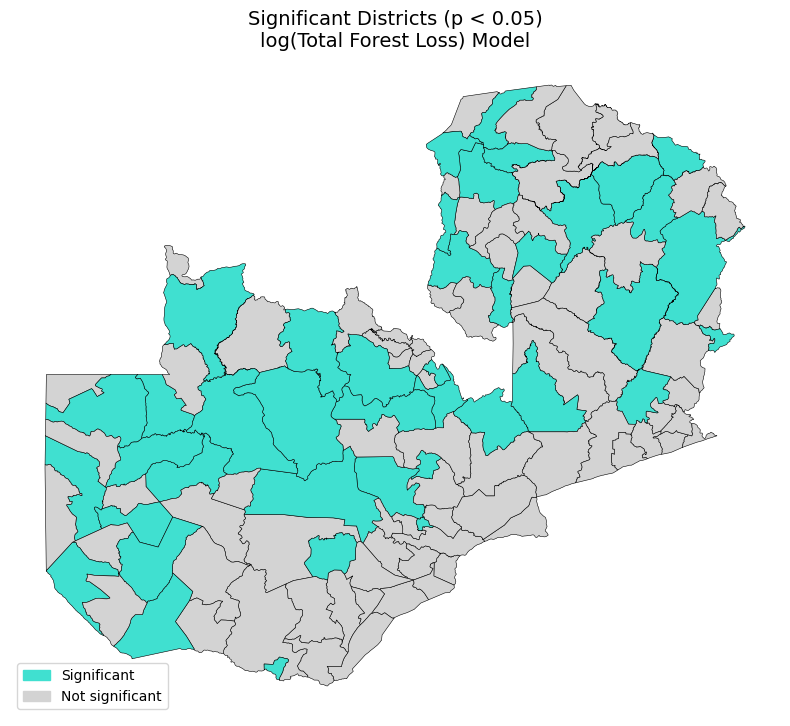

In [3]:
# map significant districts
districts_gdf = gpd.read_file('Data/district.shp')

# set crs
districts_gdf.set_crs(epsg=4326, inplace=True) 

# standardize district names
districts_gdf['district'] = districts_gdf['NAME_2'].str.strip().str.title()

# mark significant districts
districts_gdf['significant'] = districts_gdf['district'].isin(significant_district_list)

# create color column for plotting
districts_gdf['color'] = districts_gdf['significant'].map({True: 'turquoise', False: 'lightgray'})

# plot
fig, ax = plt.subplots(figsize=(8, 10))
districts_gdf.plot(ax=ax, color=districts_gdf['color'], edgecolor='black', linewidth=0.4)

ax.set_title('Significant Districts (p < 0.05)\nlog(Total Forest Loss) Model', fontsize=14)
ax.axis('off')

# legend
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='#40E0D0', label='Significant'),
    mpatches.Patch(color='lightgray', label='Not significant')
]
ax.legend(handles=legend_handles, loc='lower left')

plt.tight_layout()
plt.show()

In [12]:
# list of significant districts
significant_districts = districts_gdf[districts_gdf['significant'] == True]['district'].tolist()
significant_districts

['Chibombo',
 'Kabwe',
 'Mkushi',
 'Mumbwa',
 'Serenje',
 'Lufwanyama',
 'Masaiti',
 'Mpongwe',
 'Ndola',
 'Lundazi',
 'Mambwe',
 'Kawambwa',
 'Mansa',
 'Mwense',
 'Nchelenge',
 'Samfya',
 'Lusaka',
 'Chama',
 'Chinsali',
 'Mpika',
 'Nakonde',
 'Kabompo',
 'Kasempa',
 'Mufumbwe',
 'Mwinilunga',
 'Solwezi',
 'Zambezi',
 'Chilubi',
 'Kaputa',
 'Kasama',
 'Mporokoso',
 'Mungwi',
 'Livingstone',
 'Namwala',
 'Kalabo',
 'Kaoma',
 'Lukulu',
 'Mongu',
 'Senanga',
 'Sesheke',
 "Shang'Ombo"]

## All lags (1-5)

In [4]:
# log total forest loss

results = []

for lag in range(1, 6):
    spei_col = f'mean_spei_lag{lag}'
    interaction = f'spei{lag}_x_popdens'
    
    # create interaction term dynamically
    cleaned[interaction] = cleaned[spei_col] * cleaned['pop_density_wi']

    # define and run model
    formula = f'log_loss_m2 ~ {spei_col} + pop_density_wi + {interaction} + percent_forest_2000 + C(district)'
    model = smf.ols(formula=formula, data=cleaned).fit()

    # store summary stats
    results.append({
        'Lag': lag,
        'SPEI coef': model.params.get(spei_col, float('nan')),
        'SPEI pval': model.pvalues.get(spei_col, float('nan')),
        'Interaction coef': model.params.get(interaction, float('nan')),
        'Interaction pval': model.pvalues.get(interaction, float('nan')),
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic
    })

# convert results to table
results_df = pd.DataFrame(results)
results_df

,Lag,SPEI coef,SPEI pval,Interaction coef,Interaction pval,R-squared,Adj. R-squared,AIC,BIC
0,1,-0.054273,2.458541e-01,0.172508,6.577687e-03,0.744816,0.728360,3974.578011,4339.425040
1,2,-0.173166,2.100935e-04,0.061022,3.854692e-01,0.746073,0.729699,3968.783638,4333.630667
2,3,-0.182176,9.157815e-05,0.232361,2.719533e-04,0.749036,0.732853,3955.015720,4319.862749
3,4,-0.358128,5.165903e-15,0.239648,7.683923e-07,0.760809,0.745384,3898.658028,4263.505057
4,5,-0.199494,2.623822e-05,0.024192,5.738805e-01,0.759967,0.743453,3633.319526,3993.801583


## Plot

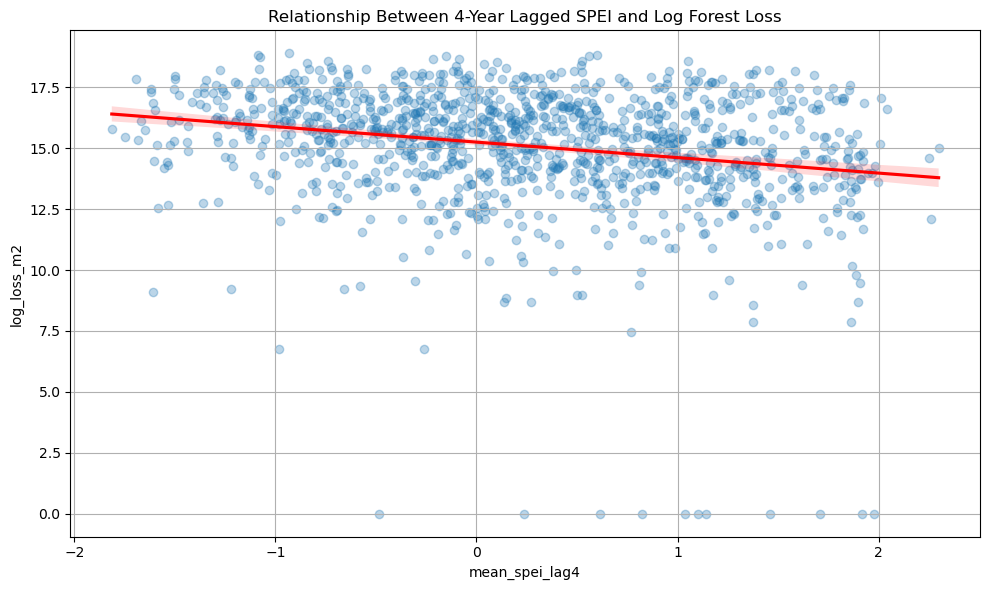

In [13]:
plt.figure(figsize=(10,6))
sns.regplot(
    data=cleaned,
    x='mean_spei_lag4',
    y='log_loss_m2',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)

plt.title('Relationship Between 4-Year Lagged SPEI and Log Forest Loss')
plt.xlabel('mean_spei_lag4')
plt.ylabel('log_loss_m2')
plt.grid(True)
plt.tight_layout()
plt.show()

## Charcoal buffer proximity analysis

In [5]:
# load survey data
df = pd.read_csv('Data/Charc.csv')

# filter for charcoal-producing households
charcoal_df = df[df['Charc'] == 1].copy()

# convert to geodataframe
charcoal_gdf = gpd.GeoDataFrame(
    charcoal_df,
    geometry=gpd.points_from_xy(charcoal_df.longitude, charcoal_df.latitude),
    crs='EPSG:4326'
)

# charcoal production counts by district
charcoal_counts = (
    df[df['Charc'] == 1]
    .groupby('district')
    .size()
    .reset_index(name='charcoal')
)

# merge with shapefile
merged = districts_gdf.merge(charcoal_counts, on='district', how='left')
merged['charcoal'] = merged['charcoal'].fillna(0)

charcoal_production = merged[merged['charcoal'] > 0].copy()

charcoal_production_utm = charcoal_production.to_crs(epsg=32735)

# get centroids
charcoal_production_utm['centroid'] = charcoal_production_utm.geometry.centroid

# create gdf of points
charcoal_points = gpd.GeoDataFrame(
    charcoal_production_utm[['district', 'charcoal']],
    geometry=charcoal_production_utm['centroid'],
    crs=charcoal_production_utm.crs
)

charcoal_points = charcoal_points.to_crs(epsg=4326)

# Extract longitude and latitude from Point geometry
charcoal_points['longitude'] = charcoal_points.geometry.x
charcoal_points['latitude'] = charcoal_points.geometry.y

# Drop the geometry column (optional)
charcoal_points_csv = charcoal_points.drop(columns='geometry')

# Export to CSV
charcoal_points_csv.to_csv('charcoal_points.csv', index=False)

# add buffers
charcoal_points_utm = charcoal_points.to_crs(epsg=32735)
districts_gdf_utm = districts_gdf.to_crs(epsg=32735)

# create 25 and 50 km buffers (in meters)
buffer_25km = charcoal_points_utm.buffer(25000)
buffer_50km = charcoal_points_utm.buffer(50000)

# convert buffers to geodataframes
buffer_25km_gdf = gpd.GeoDataFrame(geometry=buffer_25km, crs=charcoal_points_utm.crs)
buffer_50km_gdf = gpd.GeoDataFrame(geometry=buffer_50km, crs=charcoal_points_utm.crs)

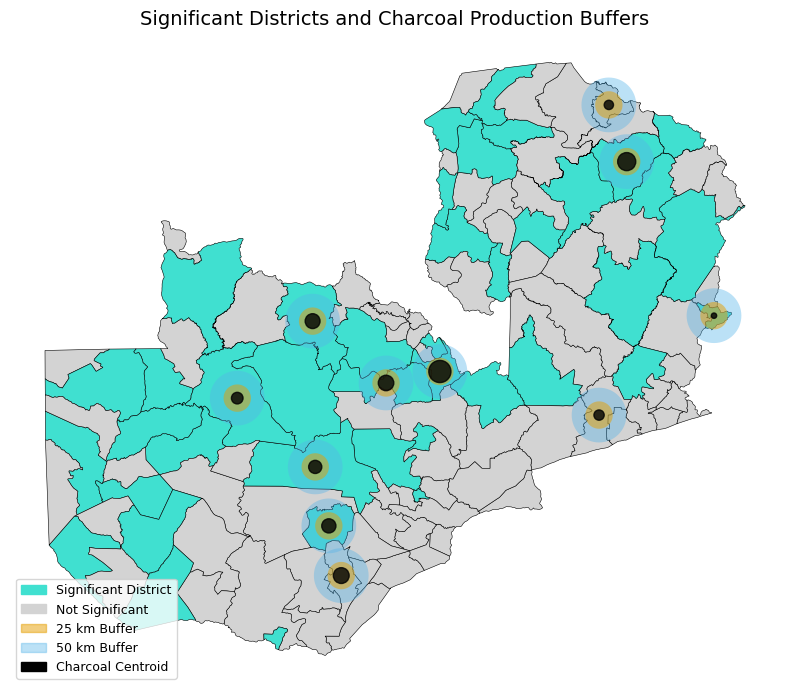

In [6]:
# reproject the base layer to match buffer CRS
districts_plot = districts_gdf.to_crs(epsg=32735)

# start new figure 
fig, ax = plt.subplots(figsize=(8, 10))

# plot base layer
districts_plot.plot(ax=ax, color=districts_plot['color'], edgecolor='black', linewidth=0.4)

# plot buffers
buffer_50km_gdf.plot(ax=ax, color='#56B4E9', alpha=0.4, edgecolor='none', label='50 km Buffer')
buffer_25km_gdf.plot(ax=ax, color='#E69F00', alpha=0.5, edgecolor='none', label='25 km Buffer')

# plot charcoal centroids
charcoal_points_utm.plot(
    ax=ax,
    color='black',
    markersize=charcoal_points_utm['charcoal'] * 5,  # scale this multiplier as needed
    alpha=0.8,
    label='Charcoal Centroid (Scaled)'
)

# add title and legend
ax.set_title('Significant Districts and Charcoal Production Buffers', fontsize=14)
ax.axis('off')

# create legend
legend_handles = [
    mpatches.Patch(color='#40E0D0', label='Significant District'),
    mpatches.Patch(color='lightgray', label='Not Significant'),
    mpatches.Patch(color='#E69F00', alpha=0.5, label='25 km Buffer'),
    mpatches.Patch(color='#56B4E9', alpha=0.4, label='50 km Buffer'),
    mpatches.Patch(color='black', label='Charcoal Centroid')
]

ax.legend(handles=legend_handles, loc='lower left', fontsize=9)

plt.tight_layout()
plt.show()

# Work in progress ahead: ignore for now

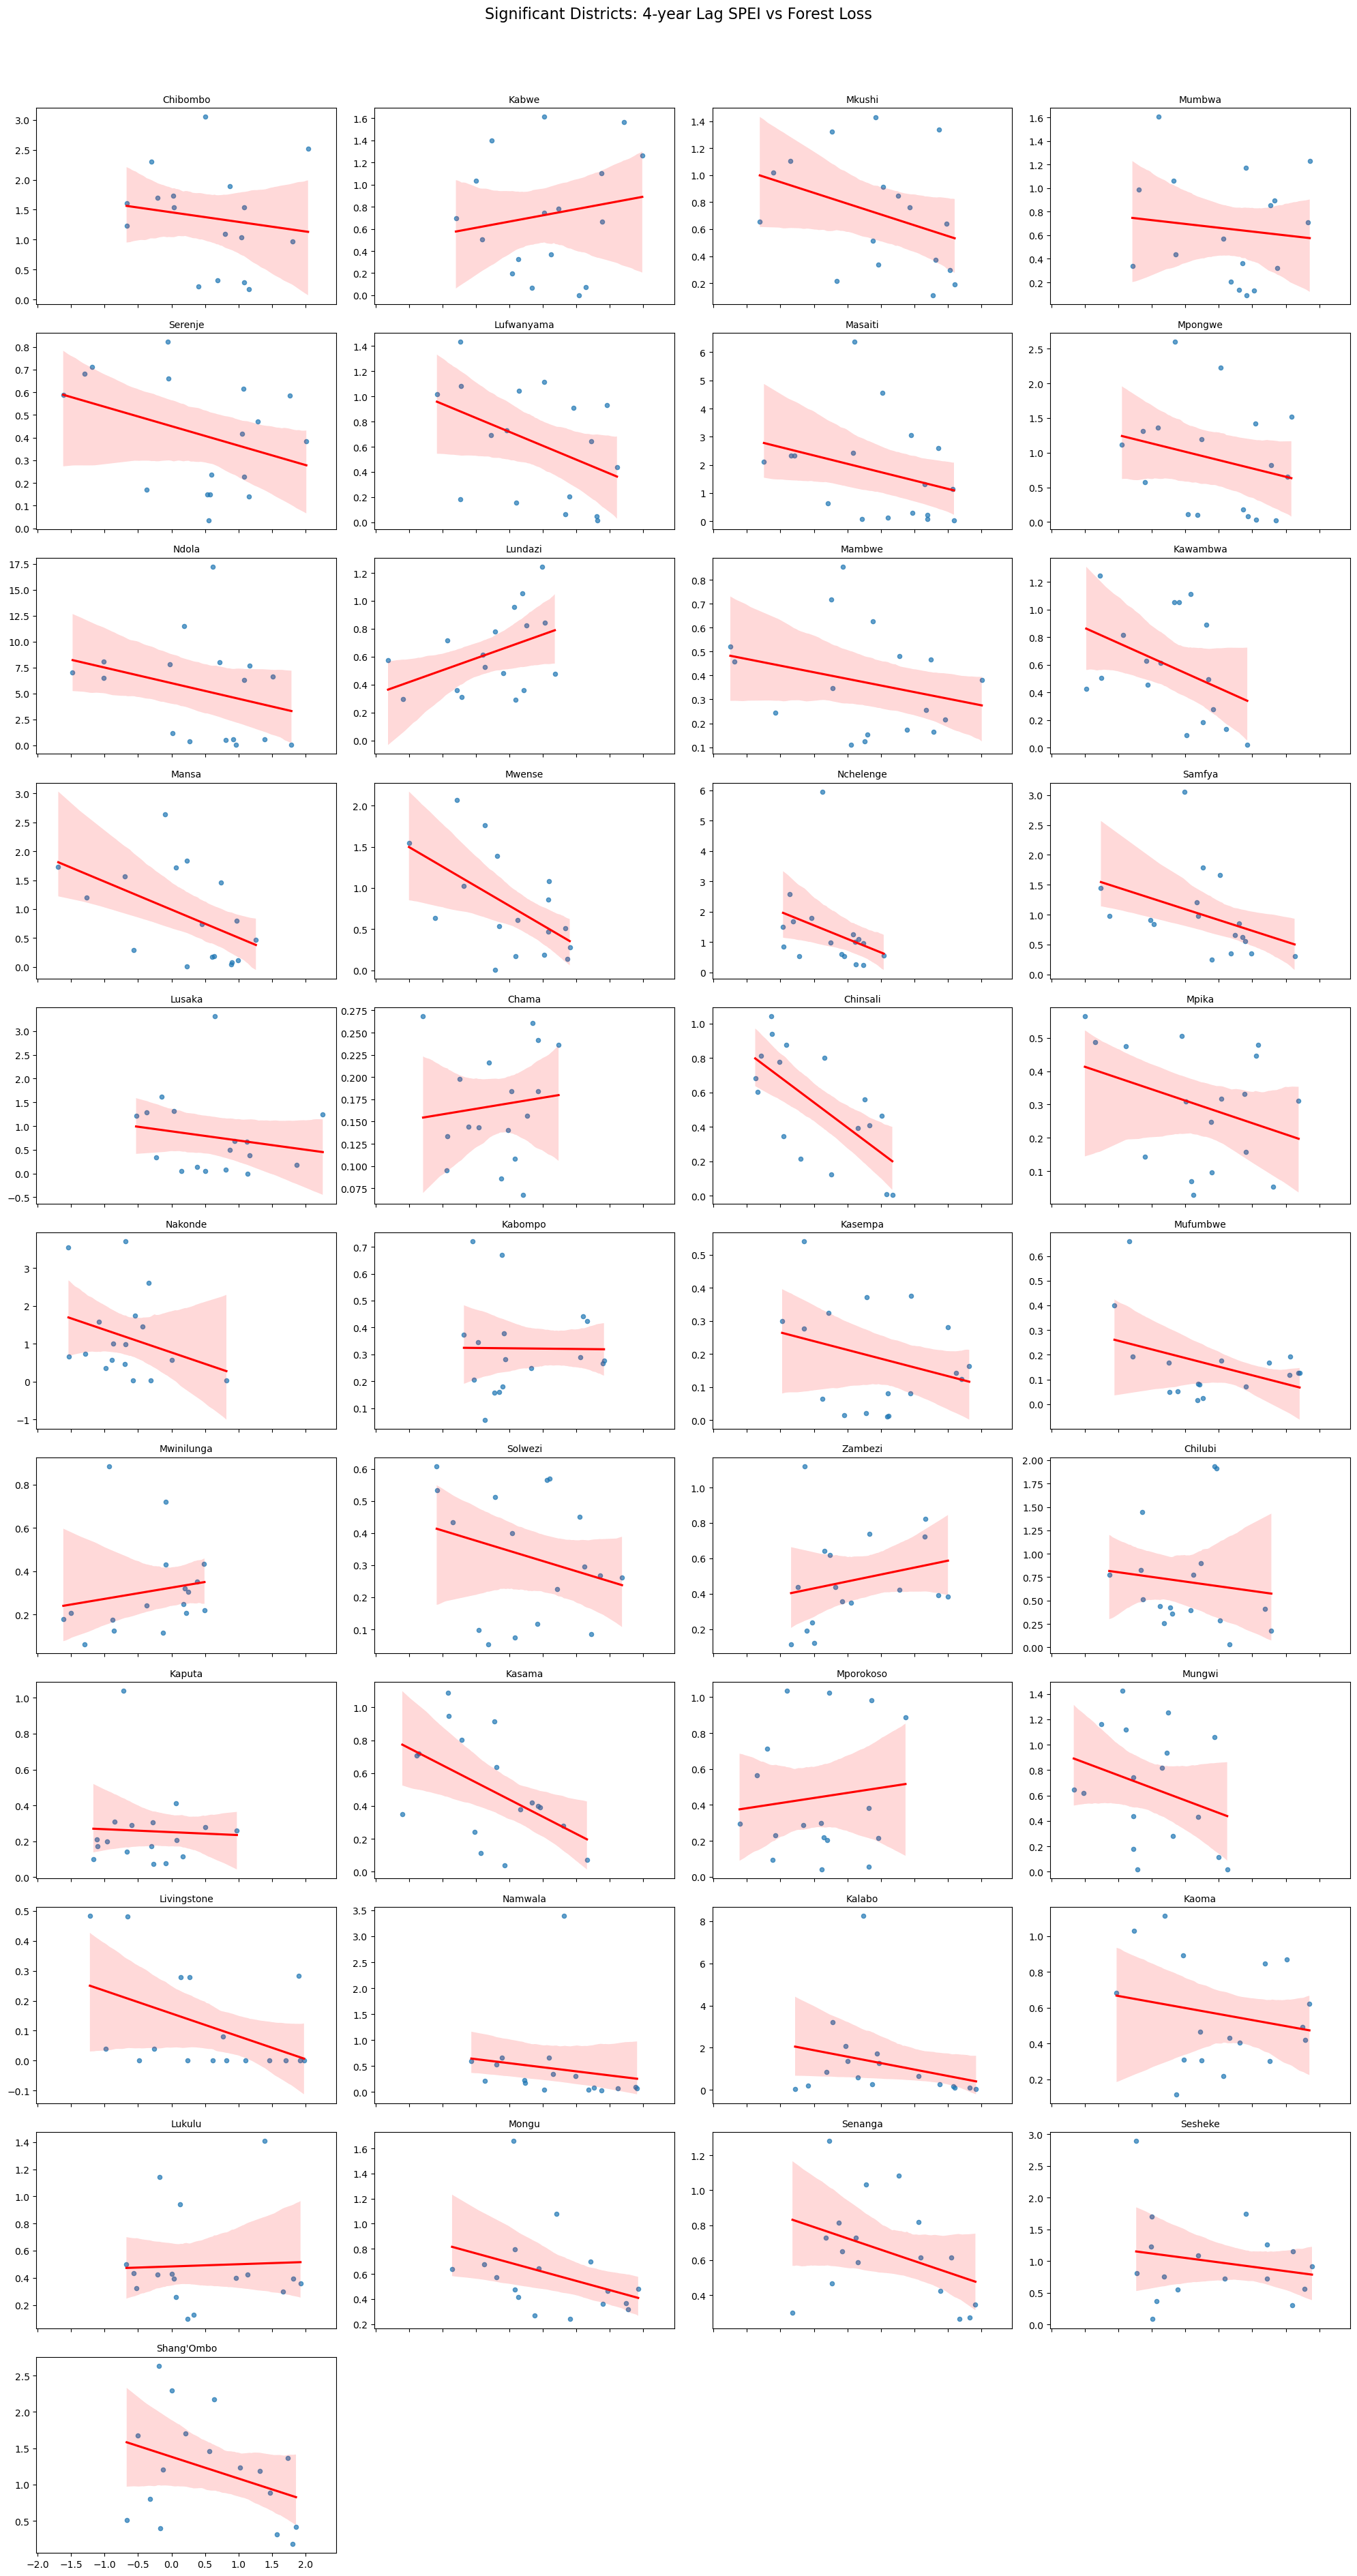

In [18]:
# statistically significant relationships between 4-yr lag SPEI and forest loss
significant_districts = [
 'Chibombo',
 'Kabwe',
 'Mkushi',
 'Mumbwa',
 'Serenje',
 'Lufwanyama',
 'Masaiti',
 'Mpongwe',
 'Ndola',
 'Lundazi',
 'Mambwe',
 'Kawambwa',
 'Mansa',
 'Mwense',
 'Nchelenge',
 'Samfya',
 'Lusaka',
 'Chama',
 'Chinsali',
 'Mpika',
 'Nakonde',
 'Kabompo',
 'Kasempa',
 'Mufumbwe',
 'Mwinilunga',
 'Solwezi',
 'Zambezi',
 'Chilubi',
 'Kaputa',
 'Kasama',
 'Mporokoso',
 'Mungwi',
 'Livingstone',
 'Namwala',
 'Kalabo',
 'Kaoma',
 'Lukulu',
 'Mongu',
 'Senanga',
 'Sesheke',
 "Shang'Ombo"
]

subset = cleaned[cleaned['district'].isin(significant_districts)]

n = len(significant_districts)
ncols = 4
nrows = math.ceil(n / ncols)

# set up figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 3.5), sharex=True, sharey=False)
axes = axes.flatten()

# plot each district
for i, district in enumerate(significant_districts):
    ax = axes[i]
    district_df = subset[subset['district'] == district]

    sns.regplot(
        data=district_df,
        x='mean_spei_lag4',
        y='percent_loss_annual',
        ax=ax,
        scatter_kws={'s': 20, 'alpha': 0.7},
        line_kws={'color': 'red'},
    )
    ax.set_title(district, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

# hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Significant Districts: 4-year Lag SPEI vs Forest Loss', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()